## Load in Python Libraries

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV

## Project - Part 1

### Import Train Data

In [2]:
x_import = np.load("data/Xtrain_Regression1.npy")
y_import = np.load("data/Ytrain_Regression1.npy")

# create global functions
X_train,Y_train,X_test,Y_test = 0,0,0,0

print(np.shape(x_import))
print(np.shape(y_import))

(100, 10)
(100, 1)


### Divide Train Data into two parts

In [3]:
def split_data(x_import,y_import,test_siz,method="sklearn"):

    if method == "sklearn":
        x_train, x_test, y_train, y_test = train_test_split(x_import, y_import, test_size=test_siz, random_state = 42)
        return (x_train,y_train,x_test,y_test)

    total_quantity = np.shape(x_import)[0]
    test_quantity = int(test_siz*total_quantity)
    train_quantity = total_quantity - test_quantity

    x_train = np.zeros(shape=(train_quantity, np.shape(x_import)[1]))
    y_train = np.zeros(shape=(train_quantity, np.shape(y_import)[1]))
    x_test = np.zeros(shape=(test_quantity, np.shape(x_import)[1]))
    y_test = np.zeros(shape=(test_quantity, np.shape(y_import)[1]))


    if method == "random":
        random_index = random.sample(range(0, total_quantity), test_quantity)
        train_index, test_index = 0, 0
        for i in range(np.shape(x_import)[0]):
            if i not in random_index:
                x_train[train_index] = x_import[i]
                y_train[train_index] = y_import[i]
                train_index += 1
            elif i in random_index:
                x_test[test_index] = x_import[i]
                y_test[test_index] = y_import[i]
                test_index += 1
        return (x_train,y_train,x_test,y_test)

    # deprecated method, splits the last elements
    if method == "last_elements":
        x_train = x_import[0:-1*test_quantity] 
        x_test = x_import[train_quantity:]
        y_train = y_import[0:-1*test_quantity]
        y_test = y_import[train_quantity:]

        return (x_train,y_train,x_test,y_test)
   

# Split the data using the function above with random method
(x_train,y_train,x_test,y_test) = split_data(x_import,y_import,0.2)
np.shape(x_train)

(80, 10)

### Create Functions to implement the models

#### SSE function and Beta

In [4]:
def calc_SSE(y_pred,y):
    return np.sum((y_pred - y)**2)

def calc_SSE_beta(x,y,beta):
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])
    SSE = np.linalg.norm(y - np.matmul(X,np.transpose(beta)))**2
    return SSE

def beta_from_model(model):
    beta = model.coef_[0]
    beta[0] = model.intercept_[0]
    return beta

#### Linear Model

In [5]:
def linear_model(x, y, method="custom"):

    #add collumn of ones
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])

    if method == "custom":

        XT = np.transpose(X) #transpose ones
        XT_X = np.matmul(XT,X) # Find X^t*X
        XT_X_inv = np.linalg.inv(XT_X) # Find inverse
        XT_Y = np.matmul(XT,y) # Find X^t*y
        beta = np.matmul(XT_X_inv,XT_Y) # Find beta

        ## beta = np.linalg.tensorsolve(xt_x,xt_y) #solve for beta the equation: xt_x * beta = xt_y

        return beta
    
    if method == "sklearn":
        LR = LinearRegression()
        LR.fit(x,y)
        beta = LR.coef_
        return LR, beta.reshape(np.shape(x_train)[1],1)


    if method == "auto":

        model_auto = np.linalg.lstsq(X,y,rcond=None)
        beta = model_auto[0]
        SSE = model_auto[1][0]
        return beta

def test_linear_model(x_train,y_train,x_test,y_test):

    methods = ["custom","auto","sklearn"]
    beta, SSE = [], []
    
    beta_custom = linear_model(x_train, y_train, methods[0])
    beta_auto = linear_model(x_train, y_train, methods[1])
    model_sl, beta_sl = linear_model(x_train, y_train, methods[2])
        


    col = np.ones((np.shape(x_test)[0],1))
    X = np.hstack([col,x_test])
    y_pred_custom = np.matmul(X, beta_custom)
    y_pred_auto = np.matmul(X,beta_auto)
    y_pred_sklearn = model_sl.predict(x_test)
    #IMPORTANTE SKLEARN PARECE NÃO DAR BETA0 pq dimbeta=(10,1)
    SSE_custom = calc_SSE(y_pred_custom, y_test)
    SSE_auto = calc_SSE(y_pred_auto, y_test)
    SSE_sklearn = calc_SSE(y_pred_sklearn, y_test)
    
    return(SSE_custom,SSE_auto,SSE_sklearn)

#### Polynomial Model

In [6]:
def polynomial_model(x, y, deg, method="auto"):

    if method == "auto":
        poly = PolynomialFeatures(degree=deg, include_bias=False)  
        poly_features = poly.fit_transform(x)  
        poly_reg_model = LinearRegression()  
        poly_reg_model.fit(poly_features, y)
        return poly_reg_model, poly

def test_polynomial_model(x_train,y_train,x_test,y_test):
    deg_max = 6
    SSE = []
    order_list = [i for i in range(1,deg_max+1)]

    

    for i in range(1,deg_max+1):
        (model,poly) = polynomial_model(x_train,y_train,i)
        x_test_trans = poly.transform(x_test)
        y_pred = model.predict(x_test_trans)

        SSE.append( calc_SSE(y_pred,y_test) )
    

    plt.scatter(order_list, SSE)
    
    plt.xlabel('order')
    plt.ylabel('SSE')
    
    plt.title('SSE vs Polynomial Order')
    plt.show()

    return SSE

#### Ridge Model

In [7]:
def ridge_model(x,y,alpha,method="sklearn"):

    if method == "sklearn":
        model = Ridge(alpha=alpha)
        model.fit(x,y)
        return model


def test_ridge_model(x_train,y_train,x_test,y_test):

    alpha_list = [i for i in np.arange(0.1,2.0,0.1)]
    SSE = []

    for alpha in alpha_list:
        model = ridge_model(x_train,y_train,alpha)
        y_pred = model.predict(x_test)
        SSE.append(calc_SSE(y_pred,y_test))

    min_SSE = min(SSE)
    min_SSE_index = SSE.index(min_SSE)
    print("Min SSE:",min_SSE,"\nAlpha with min SSE:",alpha_list[min_SSE_index])
    
    plt.plot(alpha_list, SSE)
    
    plt.xlabel('alpha')
    plt.ylabel('SSE')
    
    plt.title('SSE vs Alpha')
    plt.show()

def test_ridge_model_specific_alph(x_train,y_train,x_test,y_test,alph):
    model = ridge_model(x_train,y_train,alph)
    beta = beta_from_model(model)
    ytrain_pred = model.predict(x_train)
    y_pred = model.predict(x_test)
    SSE_train = calc_SSE(ytrain_pred,y_train)
    SSE_test = calc_SSE(y_pred,y_test)
    
    return (beta,SSE_train,SSE_test)

#### Lasso Model

In [8]:
#This model has to be build in a different way
def lasso_model(x_train,y_train,alpha,method=2):

    if method == 1:
        #incomplete 
        model = Lasso()
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        #define alpha grid as a dictionary
        grid = dict()
        grid['alpha'] = np.arange(0, 1, 0.01)
        #search the grid
        search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
        lasso_model = search.fit(x_train,y_train)
        print('MAE: %.3f' % lasso_model.best_score_)
        print('Config: %s' % lasso_model.best_params_)
    
    elif method == 2:
        model_lasso = Lasso(alpha=alpha)
        model_lasso.fit(x_train,y_train)
        return model_lasso
    
def test_lasso_model(x_train,y_train,x_test,y_test):
    alpha_list, SSE = [i for i in np.arange(0.01,5,0.01)], []
    for alpha in alpha_list:
        model = lasso_model(x_train,y_train,alpha,method=2)
        y_pred = model.predict(x_test)
        SSE.append(calc_SSE(y_pred,y_test))
    
    min_SSE = min(SSE)
    min_SSE_index = SSE.index(min_SSE)
    print("Min SSE:",min_SSE,"\nAlpha with min SSE:",alpha_list[min_SSE_index])
    
    plt.plot(alpha_list, SSE)
    
    plt.xlabel('alpha')
    plt.ylabel('SSE')
    
    plt.title('SSE vs Alpha')
    plt.show()

### Test Data

#### Test Linear Model

In [9]:
SSE_linear = test_linear_model(x_train,y_train,x_test,y_test)
print("SSE from linear custom:", SSE_linear[0], "\nSSE from linear auto:", SSE_linear[1],"\nSSE from sklearn:",SSE_linear[2])

SSE from linear custom: 0.2942703136072816 
SSE from linear auto: 0.2942703136072838 
SSE from sklearn: 0.29427031360728184


#### Test Polynomial Model

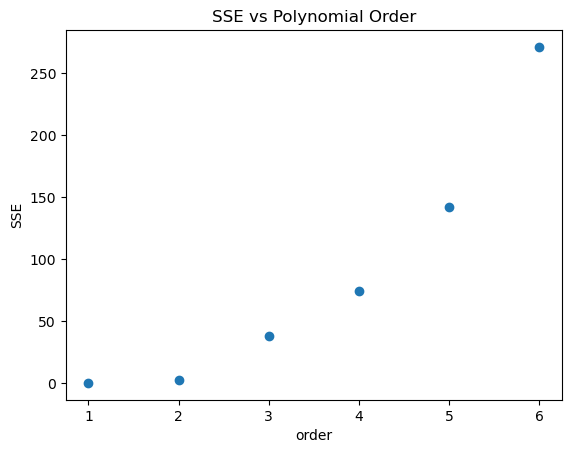

SSE order 1 : 0.29427031360728184
SSE order 2 : 2.338694917521702
SSE order 3 : 38.008291060160765
SSE order 4 : 74.2687331992969
SSE order 5 : 142.08665520168094
SSE order 6 : 271.36699176509745


In [10]:
SSE_poly = test_polynomial_model(x_train,y_train,x_test,y_test)
for i in range(len(SSE_poly)):
    print("SSE order",i+1,":",SSE_poly[i])

#### Test Ridge Model

(80, 10)
Min SSE: 0.2825953105607698 
Alpha with min SSE: 0.7000000000000001


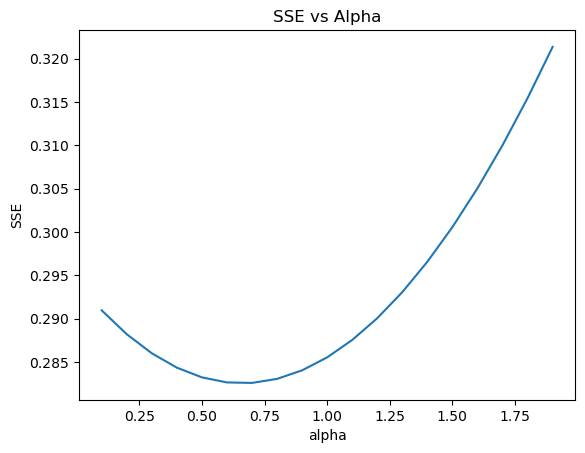

beta (ridge, alp=0.7) = [-1.43140307e-03  7.74129726e-03  8.71086240e-02  3.48032423e-01
 -6.96380137e-01  1.68420862e+00  7.16218708e-02  1.79798087e+00
 -1.10768420e-02  7.69456350e-03]
SSE from train (ridge, alp=0.7) = 0.7915650818869042
SSE from test (ridge, alp=0.7) = 0.2885194112642235


In [11]:
# Split the data using the function above with random method
(x_train,y_train,x_test,y_test) = split_data(x_import,y_import,0.2)
print(np.shape(x_train))

test_ridge_model(x_train,y_train,x_test,y_test)
(beta_ridge,SSE_train_ridge,SSE_test_ridge) = test_ridge_model_specific_alph(x_train,y_train,x_test,y_test,0.7)
print("beta (ridge, alp=0.7) =",beta_ridge)
print("SSE from train (ridge, alp=0.7) =",SSE_train_ridge)
print("SSE from test (ridge, alp=0.7) =",SSE_test_ridge)

#### Test Lasso Model

Min SSE: 2737.138072581035 
Alpha with min SSE: 1.59


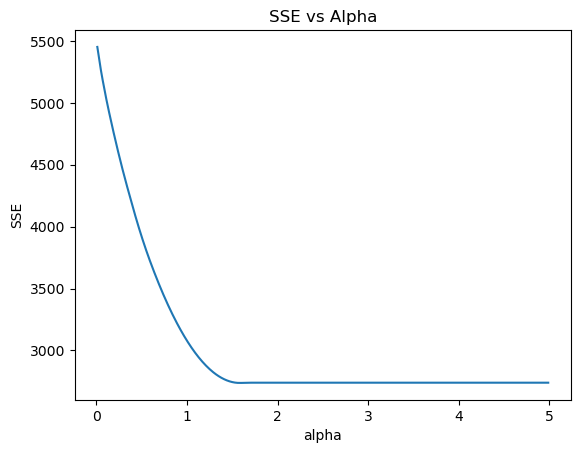

In [12]:
test_lasso_model(x_train,y_train,x_test,y_test)

#### Parameters and SSE direct from all data in the linear model

In [13]:
# (beta_linear, SSE_linear) = linear_model_func(x_import,y_import, method="custom")
# (beta_linear2, SSE_linear2) = linear_model_func(x_import,y_import, method="auto")

#### Other Tests

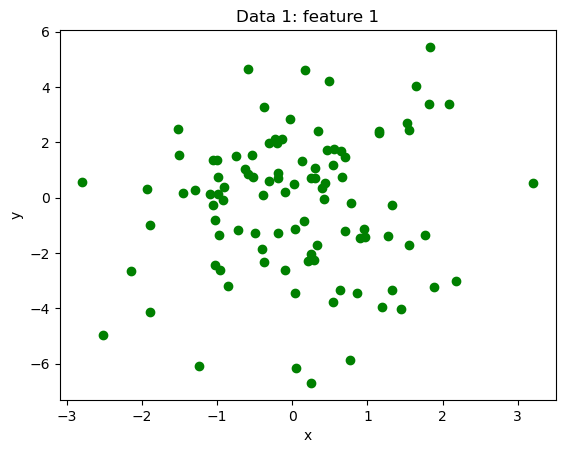

In [14]:
feature = 2
ax = plt.gca()
ax.plot(x_import[:,feature],y_import,"go")
plt.axis('tight')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Data 1: feature "+str(feature-1))
plt.show()

In [15]:
(beta_linear2, SSE_linear2) = linear_model_func(x_import,y_import, method="custom")

extra = np.full_like(x_import[:,0],beta_linear2[0])
for i in range(1,np.shape(beta_linear2)[0]-1):
    extra = extra + beta_linear2[i]*x_import[:,i-1]

# x_import[:,feature]
feature = 2
ax = plt.gca()
ax.plot(extra,y_import,"go")
plt.axis('tight')
plt.xlabel('x2')
plt.ylabel('y2')
plt.title("Data 2 with outliars: feature "+str(feature-1))
plt.show()

NameError: name 'linear_model_func' is not defined

### Estimate Final Test Set

In [ ]:
x_test_import = np.load("data/Xtest_Regression1.npy")
# Create x_test from x_test_import
x1 = np.ones((np.shape(x_test_import)[0],1))
xfinal_test= np.hstack((x1,x_test_import))
# beta_final = np.copy(betadiv_linear)

# Result estimated 
# result = np.matmul(xfinal_test,beta_final)
# print(np.shape(beta_final))
# print(np.shape(xfinal_test))
# print(np.shape(result))

### Other Graphs

#### Ridge

##### Varying Alpha

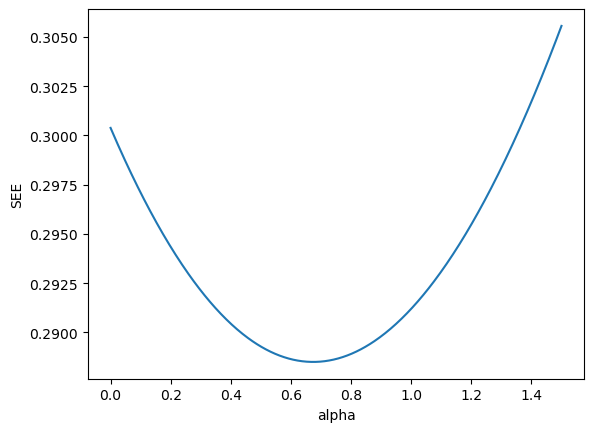

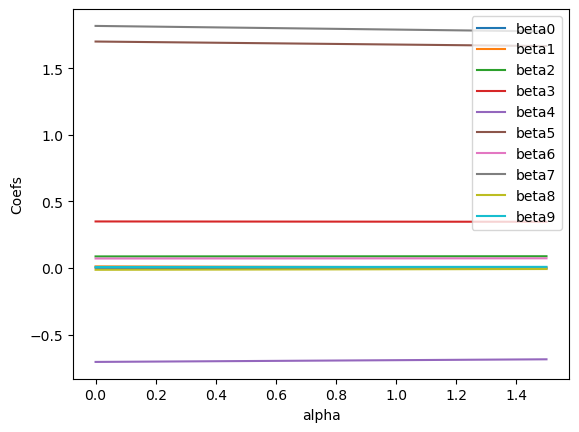

Min SSE: 0.2885022223933799 
Alpha with min SSE: 0.6733466933867736
Beta at min [-1.34530352e-03  7.88734001e-03  8.70854929e-02  3.48075744e-01
 -6.96730531e-01  1.68481203e+00  7.15949245e-02  1.79871383e+00
 -1.11812560e-02  7.68011952e-03]


In [ ]:
alphas = np.linspace(0,1.5,500)
SSEs_train = []
SSEs_test = []
coefs = []
y_test_result = []
SSE_test = []

for a in alphas:
    (beta_ridge,SSE_train_ridge,SSE_test_ridge) = test_ridge_model_specific_alph(x_train,y_train,x_test,y_test,a)
    SSEs_train.append(SSE_train_ridge)
    SSEs_test.append(SSE_test_ridge)
    coefs.append(beta_ridge)

ax = plt.gca()
ax.plot(alphas, SSEs_test)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('SEE')
plt.show()

ax2 = plt.gca()
ax2.plot(alphas, coefs)
ax2.legend(["beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8","beta9","beta10"])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.show()

min_SSE = min(SSEs_test)
min_SSE_index = SSEs_test.index(min_SSE)
print("Min SSE:",min_SSE,"\nAlpha with min SSE:",alphas[min_SSE_index])
print("Beta at min",coefs[min_SSE_index])

##### Varying Alpha and Data

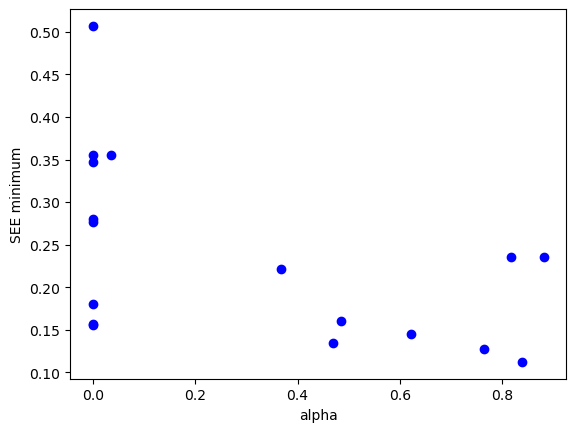

In [ ]:
alp_min = []

for i in range(1, 18):
    # (xrand_train,yrand_train,xrand_test,yrand_test) = split_data(x_import,y_import,0.05*i)
    (xrand_train,yrand_train,xrand_test,yrand_test) = split_data(x_import,y_import,0.2,method="random")
    alphas = np.linspace(0,1.5,500)
    SSEs_train = []
    SSEs_test = []
    coefs = []
    y_test_result = []
    SSE_test = []

    for a in alphas:
        (beta_ridge,SSE_train_ridge,SSE_test_ridge) = test_ridge_model_specific_alph(xrand_train,yrand_train,xrand_test,yrand_test,a)
        SSEs_train.append(SSE_train_ridge)
        SSEs_test.append(SSE_test_ridge)
        coefs.append(beta_ridge)

    min_SSE = min(SSEs_test)
    min_SSE_index = SSEs_test.index(min_SSE)
    alp_min.append([alphas[min_SSE_index],min_SSE])
    # print(0.1*i)
    # print("Min SSE:",min_SSE,"\nAlpha with min SSE:",alphas[min_SSE_index])
    # print("Beta at min",coefs[min_SSE_index])


ax = plt.gca()
ax.plot(np.transpose(alp_min)[0],np.transpose(alp_min)[1], "bo")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('SEE minimum')
plt.show()

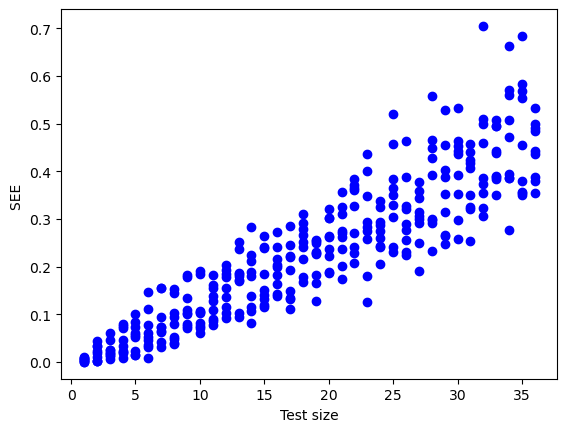

In [ ]:
divider = np.linspace(1,36,36)
div_SSE = []

for i in range(1, 10):
    SSEs_train = []
    SSEs_test = []
    coefs = []
    y_test_result = []
    SSE_test = []
    
    for a in divider:
        (xrand_train,yrand_train,xrand_test,yrand_test) = split_data(x_import,y_import,int(a)/100,method="random")
        beta_train = linear_model(xrand_train,yrand_train, method="custom")
        (SSE_custom,SSE_auto,SSE_sklearn) = test_linear_model(xrand_train,yrand_train,xrand_test,yrand_test)
        SSEs_test.append(SSE_custom)
        coefs.append(beta_train)

    div_SSE.append(np.transpose(np.vstack((divider,SSEs_test))))

ax = plt.gca()
ax.plot(np.transpose(div_SSE)[0],np.transpose(div_SSE)[1], "bo")
plt.axis('tight')
plt.xlabel('Test size')
plt.ylabel('SEE ')
plt.show()

#### Lasso

In [ ]:
def lasso_model(x,y,alph):
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])
    reg_lasso = linear_model.Lasso(alpha=alph,normalize=False)
    reg_lasso.fit(X,y)
    beta = reg_lasso.coef_
    beta[0] = reg_lasso.intercept_[0]
    SSE = np.linalg.norm(y - np.matmul(X,np.transpose(reg_lasso.coef_)))**2
    return (beta,SSE)

(beta_lasso,SSE_lasso) = lasso_model(x_import,y_import,2)
print("beta (lasso) =",beta_lasso)
print("SSE from train (lasso) =",SSE_lasso)

alphas = np.linspace(10,1000,100)
SSEs_train = []
SSEs_test = []
coefs = []
y_test_result = []
SSE_test = []

(xdiv_train,ydiv_train,xdiv_test,ydiv_test) = split_data(x_import,y_import,95,np.shape(x_import)[0],method="random")

for a in alphas:
    (beta_train,SSE_train) = lasso_model(xdiv_train,ydiv_train,a)
    (y_test_result,SSE_test) = test_linear_model(xdiv_test,beta_train,ydiv_test)
    SSEs_train.append(SSE_train)
    SSEs_test.append(SSE_test)
    coefs.append(beta_train)

ax = plt.gca()
ax.plot(alphas, SSEs_test)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('SEE')
plt.show()

ax2 = plt.gca()
ax2.plot(alphas, coefs)
ax2.legend(["beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8","beta9","beta10"])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.show()

AttributeError: 'function' object has no attribute 'Lasso'

In [ ]:
from sklearn import decomposition, datasets
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

std_slc = StandardScaler()

pca = decomposition.PCA()

lasso = linear_model.Lasso()

pipe = Pipeline(steps=[("std_slc", std_slc),
                       ("pca", pca),
                       ("lasso", lasso)])

n_components = list(range(1,x_import.shape[1]+1,1))

normalize = [True, False]
selection = ["cyclic", "random"]

parameters = dict(pca__n_components=n_components,
                  lasso__normalize=normalize,
                  lasso__selection=selection)

clf = GridSearchCV(pipe, parameters)
clf.fit(x_import, y_import)

print("Best Number Of Components:", clf.best_estimator_.get_params()["pca__n_components"])
print(clf.best_estimator_.get_params()["lasso"])

CV_Result = cross_val_score(clf, x_import, y_import, cv=11, n_jobs=-1, scoring="r2")
print(CV_Result)
print(CV_Result.mean())
print(CV_Result.std())
(y_test_result,SSE_test) = test_linear_model(x_import,CV_Result,y_import)    
SSE_test
    

Best Number Of Components: 8
Lasso()
[ 0.37974183  0.20657802  0.09560438  0.07809858  0.39385889 -0.07327867
 -0.20611151 -0.22863496  0.30775314  0.05084572  0.16721297]
0.1065153081414926
0.2040109723351131


70880.94946087559